In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Concatenate, Multiply, Permute, Lambda, Reshape, Activation, Dropout, Add, GlobalMaxPooling1D, GlobalAvgPool1D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import pydot, graphviz

### Load the data from CSV files

In [21]:
# List all of the CSV file paths
stator_csv_files = [r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\01_SCIM_current_allfault_360V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\02_SCIM_current_PTPab_400V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\03_SCIM_current_PTPab_480V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\04_SCIM_current_PTGa_360V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\05_SCIM_current_PTGb_360V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\06_SCIM_current_PTGc_360V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\07_SCIM_current_PTPbc_400V.csv"]

rotor_csv_files = [r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\01_SCIM_vibration_allfault_360V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\02_SCIM_vibration_PTPab_400V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\03_SCIM_vibration_PTPab_480V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\04_SCIM_vibration_PTGa_360V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\05_SCIM_vibration_PTGb_360V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\06_SCIM_vibration_PTGc_360V.csv",
r"D:\MTdataset\DL_dataset\Simulink_data_generation\Final_current_vibration_data\07_SCIM_vibration_PTPbc_400V.csv"]

# Read the CSV files into pandas dataframe and convert to numpy arrays
stator_data = [pd.read_csv(file).values for file in stator_csv_files]
rotor_data = [pd.read_csv(file).values for file in rotor_csv_files]


### Data generator function

In [22]:
def data_generator(stator_data, rotor_data, sequence_length=100, batch_size=32):
    # get the number of samples
    num_samples = stator_data[0].shape[0] - sequence_length     

    # Infinite loop to continuously yield the batches
    while True:
        # Generate batches
        for start_idx in range(0, num_samples, batch_size):
            stator_batch = []
            rotor_batch = []
            batch_y = []

            for i in range(batch_size):
                end_idx = start_idx + i + sequence_length
                if end_idx >= num_samples:
                    break

            # Create sequences of length 'Sequence length'
            stator_seq = [data[start_idx + i:end_idx, 1:] for data in stator_data] # excluding the time column
            rotor_seq = [data[start_idx + i:end_idx, 1] for data in rotor_data] # excluding the time column & vibration is the only remaining column
            
            # Target is the next time step's 'Time' value in stator data (same as rotor data)
            y = stator_data[0][end_idx, 0] # assuming time is the first column in the stator files

            stator_batch.append(np.concatenate(stator_seq, axis=-1))
            rotor_batch.append(np.concatenate(rotor_seq, axis=-1))
            batch_y.append(y)
        
        if len(stator_batch) == batch_size:
            X_stator = np.array(stator_batch)
            X_rotor = np.array(rotor_batch)
            y = np.array(batch_y)

            #concatenating data along the last axis
            yield [X_stator, X_rotor], y 

In [23]:
# Create the data generator

generator = data_generator(stator_data, rotor_data, sequence_length=100, batch_size=32)

## Create the BiLSTM network with Time and Channel attention

### Defining Time attention and Channel attention mechanisms

In [24]:
# Define the time attention mechanism 
class TimeAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(TimeAttentionLayer, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.W_omega = Dense(hidden_size, use_bias=False)
        self.b_omega = Dense(hidden_size, use_bias=False)
        self.u_omega = self.add_weight(shape=(hidden_size,), initializer='random_normal', trainable=True, name='u_omega')

    def call(self, inputs):
        u_t = tf.nn.tanh(self.W_omega(inputs) + self.b_omega(inputs))
        alpha_t = tf.nn.softmax(tf.reduce_sum(u_t * self.u_omega, axis=2, keepdims=True), axis=1)
        context_vector = tf.reduce_sum(alpha_t * inputs, axis=1)
        return context_vector

class ChannelAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, input_shape, **kwargs):
        super(ChannelAttentionLayer, self).__init__(**kwargs)
        self.input_shape_param = input_shape
        self.gmp = GlobalMaxPooling1D()
        self.gap = GlobalAvgPool1D()
        self.fcl = Dense(input_shape, activation='linear')
        self.m = Dense(input_shape // 8, activation='relu')
        self.v = Dense(input_shape // 8, activation='relu')
        self.n = Dense(input_shape // 8, activation='relu')
        self.W11 = Dense(input_shape // 8, activation='relu')
        self.W12 = Dense(input_shape, activation='linear')
        self.W21 = Dense(input_shape // 8, activation='relu')
        self.W22 = Dense(input_shape, activation='linear')

    def build(self, input_shape):
        super(ChannelAttentionLayer, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, inputs):
        inputs_reshaped = tf.expand_dims(inputs, axis=1)

        # GMP and GAP for descriptors m and v
        gmp = self.gmp(inputs_reshaped)
        gap = self.gap(inputs_reshaped)
        
        # Fully Connected Layer for descriptor n
        fcl = self.fcl(inputs)

        # Descriptors
        m = self.m(gmp)
        v = self.v(gap)
        n = self.n(fcl)

        # Multilayer Perceptrons
        W11 = self.W11(v)
        W12 = self.W12(W11)

        W21 = self.W21(m)
        W22 = self.W22(W21)

        # Combine using element-wise summation and add n
        combined = Add()([W12, W22, n])

        # Activation function to get attention weights
        attention_weights = Activation('hard_sigmoid')(combined)
        attention_weights = Reshape((1, self.input_shape_param))(attention_weights)

        # Apply attention weights
        channel_attention = Multiply()([inputs, attention_weights])
        return channel_attention

In [7]:
# Define the model with modified channel attention mechanism and dropout
def create_model(stator_input_shape, rotor_input_shape):
    hidden_size = 64 # The size used for LSTM layers
    # Stator current input
    input_stator = Input(shape=stator_input_shape, name='stator_input')
    lstm_stator = Bidirectional(LSTM(hidden_size, return_sequences=True))(input_stator)
    time_attention_stator = TimeAttentionLayer(hidden_size)(lstm_stator)
    channel_attention_stator = ChannelAttentionLayer(hidden_size * 2)(time_attention_stator)

    # Rotor vibration input
    input_rotor = Input(shape=rotor_input_shape, name='rotor_input')
    lstm_rotor = Bidirectional(LSTM(hidden_size, return_sequences=True))(input_rotor)
    time_attention_rotor = TimeAttentionLayer(hidden_size)(lstm_rotor)
    channel_attention_rotor = ChannelAttentionLayer(hidden_size * 2)(time_attention_rotor)

    # Concatenate and Dense layers with Dropout
    concatenated = Concatenate()([channel_attention_stator, channel_attention_rotor])
    dense1 = Dense(64, activation='relu')(concatenated)
    dropout1 = Dropout(0.6)(dense1)
    output = Dense(1)(dropout1)

    model = Model(inputs=[input_stator, input_rotor], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

def check_graphviz():
    try:
        # Attempt to create an image of a blank graph to check the pydot/graphviz installation.
        pydot.Dot.create(pydot.Dot())
        return True
    except (OSError, Exception) as e:
        if isinstance(e, OSError):
            print("Graphviz not found.")
        else:
            print("Some other exception occurred with pydot.")
        return False

# input shape for stator and rotor data
stator_input_shape = (100, 6) # (sequence_length, number of stator features)
rotor_input_shape = (100, 1) # (sequence_length, number of rotor features)

model = create_model(stator_input_shape, rotor_input_shape)
model.summary


In [ ]:
# Fit the model using the data generator
model.fit(generator, steps_per_epoch=(stator_data[0].shape[0] - 100) // 32, epochs=10)

In [ ]:

# Check if Graphviz is installed correctly
# if check_graphviz():
    # Save the model architecture to a file
    # plot_model(model, to_file='bilstm_model.png', show_shapes=True)
# else:
    # print("Graphviz is not installed or not in PATH.")

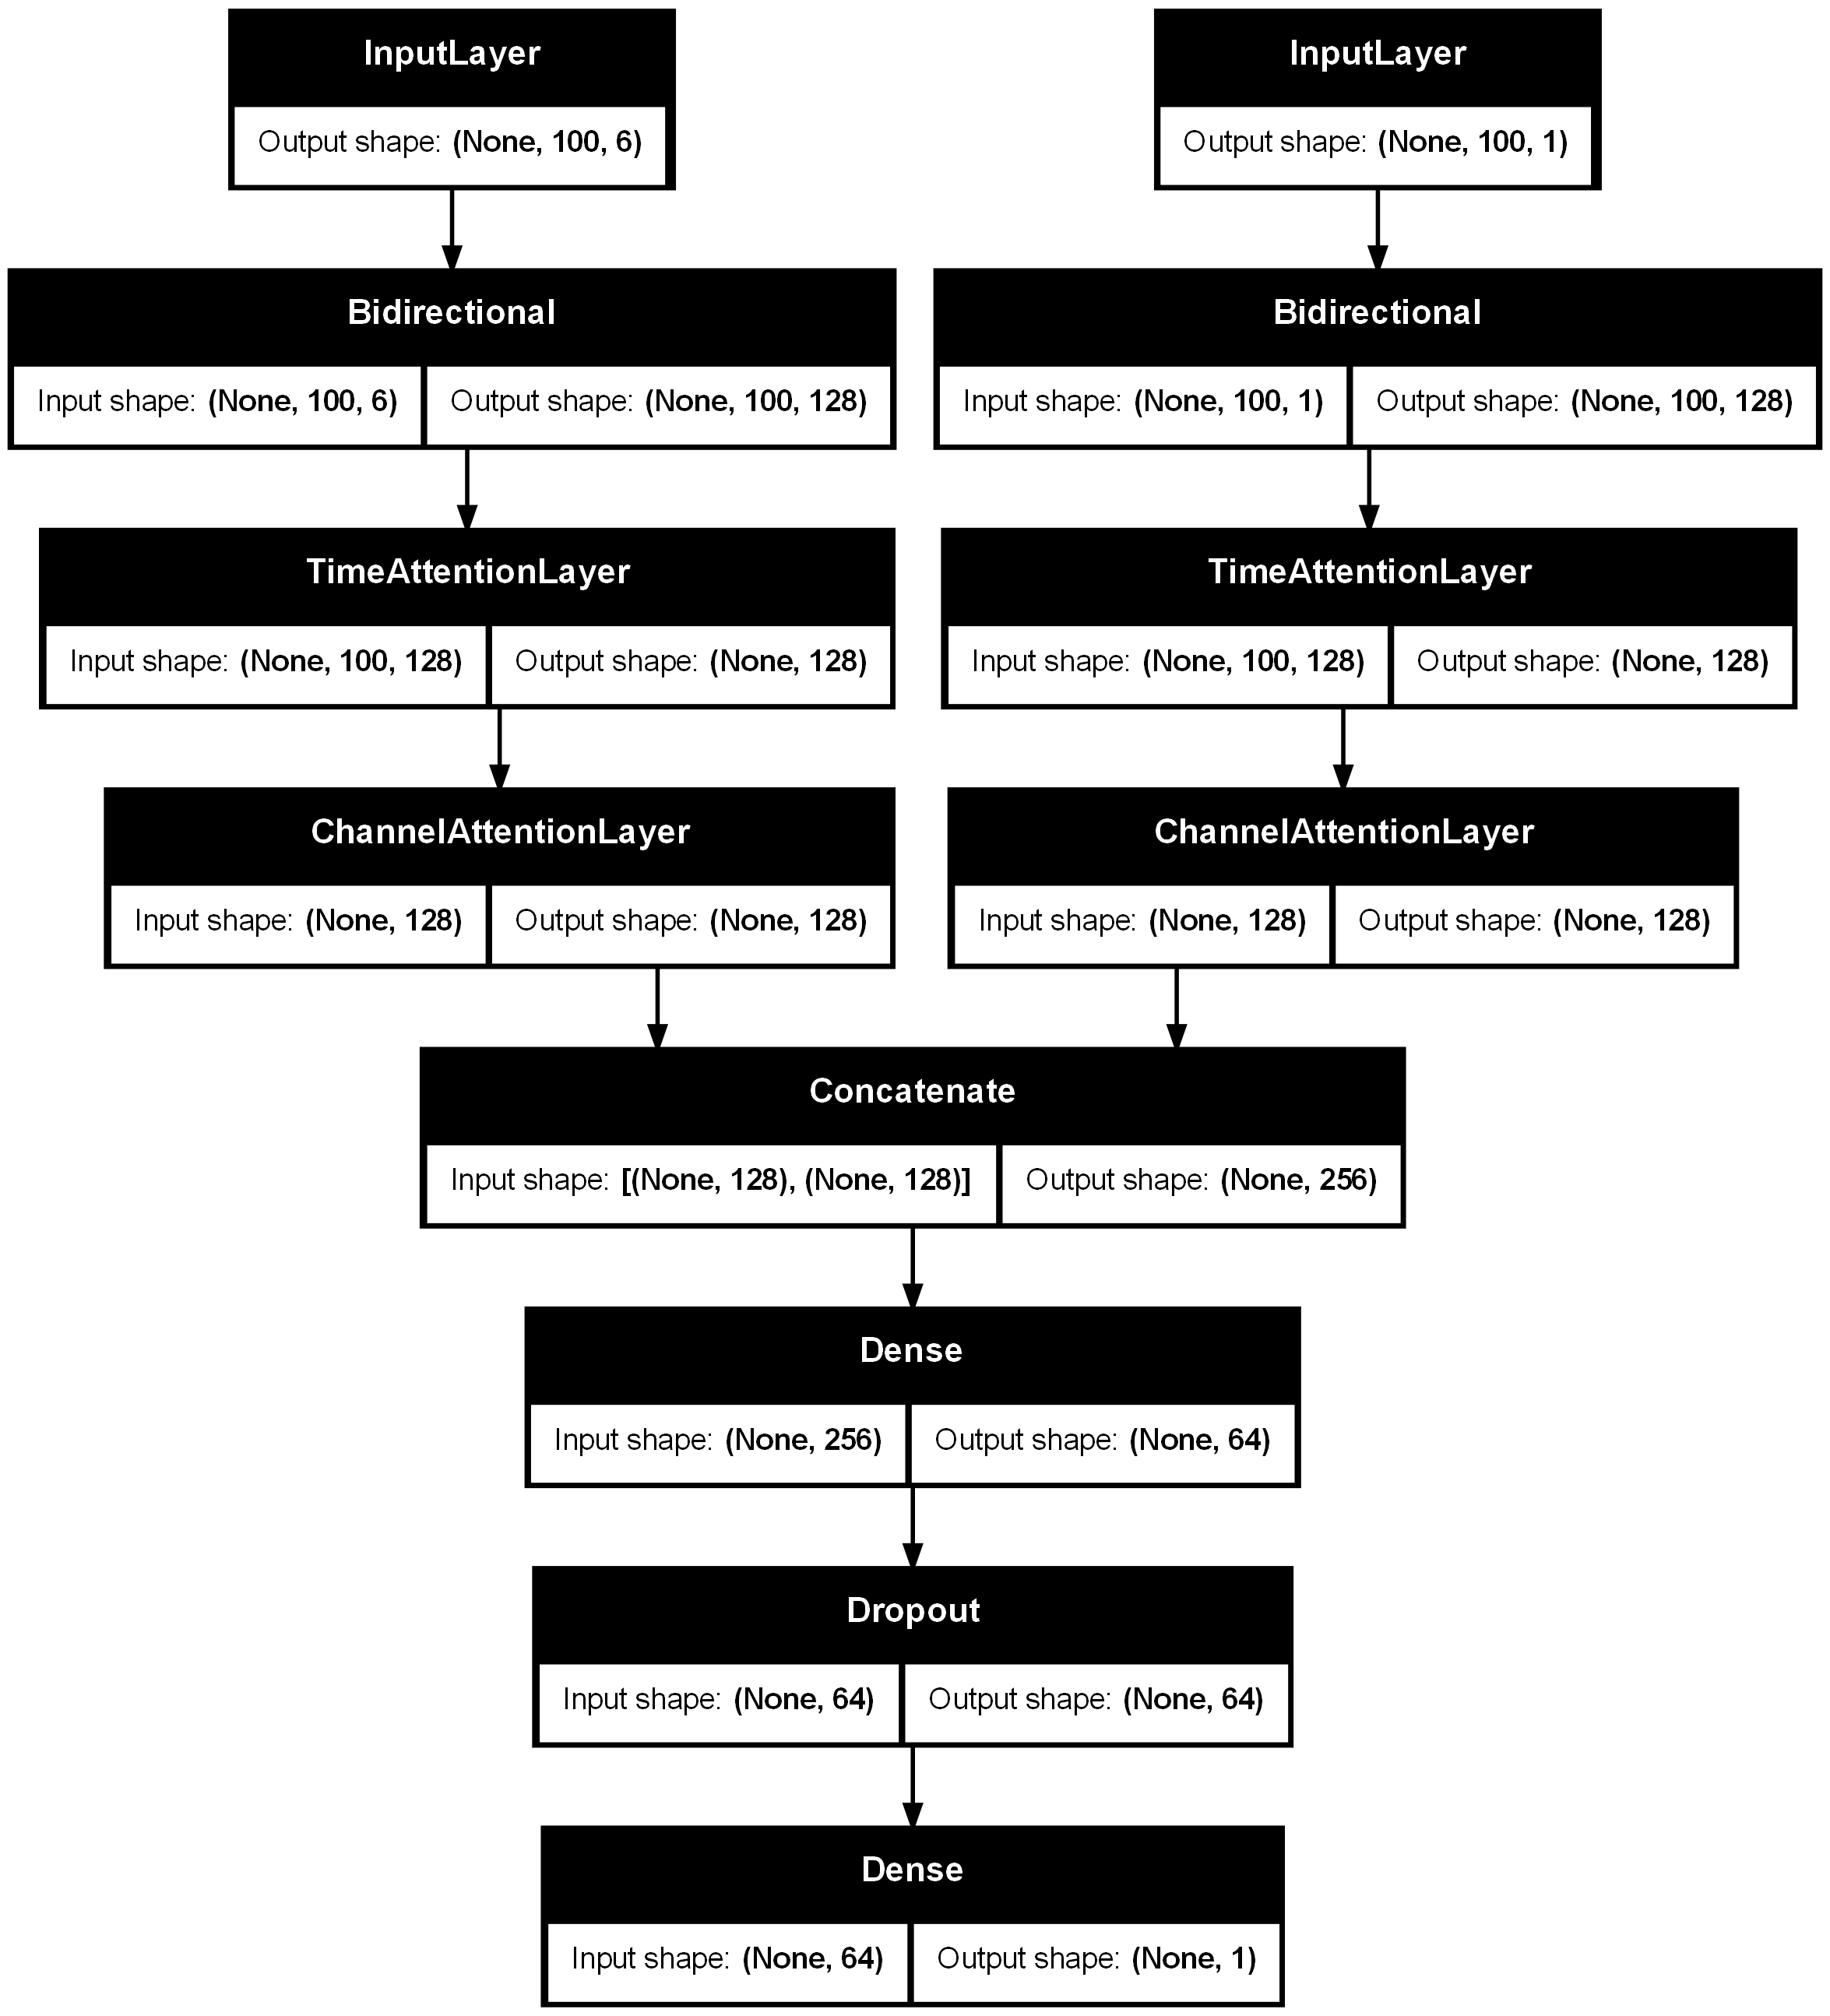

In [15]:
# Visualization Functions
def visualize_bilstm(input_shape):
    input_layer = Input(shape=input_shape)
    bilstm_layer = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    model = Model(inputs=input_layer, outputs=bilstm_layer)
    return model

def visualize_time_attention(input_shape, hidden_size):
    input_layer = Input(shape=input_shape)
    attention_output = TimeAttentionLayer(hidden_size)(input_layer)
    model = Model(inputs=input_layer, outputs=attention_output)
    return model

def visualize_channel_attention(input_shape, hidden_size):
    input_layer = Input(shape=input_shape)
    attention_output = ChannelAttentionLayer(hidden_size)(input_layer)
    model = Model(inputs=input_layer, outputs=attention_output)
    return model


bilstm_model = visualize_bilstm((100, 6))  # Adjust input_shape accordingly
plot_model(bilstm_model, to_file='bilstm_model.png', show_shapes=True)

time_attention_model = visualize_time_attention((100, 128), hidden_size=128)  # Adjust input_shape accordingly
plot_model(time_attention_model, to_file='time_attention_model.png', show_shapes=True)

channel_attention_model = visualize_channel_attention((100, 128), hidden_size=128)  # Adjust input_shape accordingly
plot_model(channel_attention_model, to_file='channel_attention_model.png', show_shapes=True)

# Visualize the entire model
plot_model(model, to_file='full_model.png', show_shapes=True)